In [1]:
# !pip install pyspark[sql] findspark --user

import sys

import findspark
findspark.init()
findspark.find()

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *


spark = SparkSession.builder \
    .appName("Spark Streaming") \
    .config("spark.driver.extraJavaOptions", "-Dcom.sun.net.ssl.checkRevocation=false") \
    .config("spark.executor.extraJavaOptions", "-Dcom.sun.net.ssl.checkRevocation=false") \
    .config("spark.jars.packages", "org.apache.spark:spark-sql-kafka-0-10_2.13:3.2.1") \
    .config("spark.sql.streaming.forceDeleteTempCheckpointLocation", "true") \
    .config("spark.executor.instances", "1") \
    .config("spark.executor.memory", "512mb") \
    .getOrCreate()

SLF4J: Class path contains multiple SLF4J bindings.
SLF4J: Found binding in [jar:file:/usr/lib/spark/jars/slf4j-log4j12-1.7.30.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: Found binding in [jar:file:/usr/lib/hadoop/lib/slf4j-log4j12-1.7.25.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: See http://www.slf4j.org/codes.html#multiple_bindings for an explanation.
SLF4J: Actual binding is of type [org.slf4j.impl.Log4jLoggerFactory]
Ivy Default Cache set to: /home/jupyter-admin/.ivy2/cache
The jars for the packages stored in: /home/jupyter-admin/.ivy2/jars
:: loading settings :: url = jar:file:/usr/lib/spark/jars/ivy-2.4.0.jar!/org/apache/ivy/core/settings/ivysettings.xml
org.apache.spark#spark-sql-kafka-0-10_2.13 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-83b97976-e542-41b7-9e94-a12d1def8286;1.0
	confs: [default]
	found org.apache.spark#spark-sql-kafka-0-10_2.13;3.2.1 in central
	found org.apache.spark#spark-token-provider-kafka-0-10

In [18]:
spark

In [4]:
!hdfs dfs -mkdir /tmp/datasets/
!hdfs dfs -copyFromLocal airport-codes.csv /tmp/datasets/airport-codes.csv

mkdir: `/tmp/datasets': File exists
copyFromLocal: `/tmp/datasets/airport-codes.csv': File exists


Вспомним старые функции:

In [7]:
def create_parquet_sink(df, file_name):
    return df \
            .writeStream \
            .format("parquet") \
            .option("path", "{f}".format(f=file_name)) \
            .option("checkpointLocation", "chk/{f}".format(f=file_name)) \
            .trigger(processingTime="5 seconds")

def kill_all():
    streams = SparkSession.builder.getOrCreate().streams.active
    if streams:
        for s in streams:
            desc = s.lastProgress["sources"][0]["description"]
            s.stop()
            print("Stopped {s}".format(s=desc))
            
def create_console_sink(chk_name, df):
    return df \
        .writeStream \
        .outputMode("append") \
        .format("console") \
        .trigger(processingTime="10 seconds") \
        .option("checkpointLocation", "/tmp/chk/{n}".format(n=chk_name)) \
        .option("truncate", "false") \
        .option("numRows", "20")
            
from pyspark.sql.functions import col
from pyspark.sql.functions import shuffle, array, lit

def random_ident():
    csv_options = {"header": "true", "inferSchema": "true"}
    airports = spark.read.options(**csv_options).csv("/tmp/datasets/airport-codes.csv")
    idents_rows = airports.select(col("ident")).limit(200).distinct().collect()
    idents = [row["ident"] for row in idents_rows]
    idents_cols = [lit(i) for i in idents]
    idents_array = array(*idents_cols)
    shuffled = shuffle(idents_array)
    rand_ident = shuffled[0]
    return rand_ident

## На этом занятии
+ Что такое stateful streaming
+ Удаление дубликатов
+ Агрегаты
+ Соединения

В потоковом пайплайне важно понимать разделение операций на stateless и stateful.

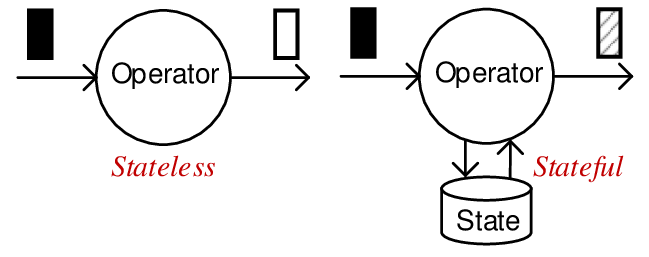

## Что такое stateful streaming

**stateful streaming** - это вид поточной обработки данных, при которой при обработке батча с данными используются данные из предыдущих батчей

Все операции с использованием select, filter, withColumn (кроме операций с плавающими окнами) являются stateless. На практике это означает:
- стрим не выполняет операций, требующих работы с данными из разных батчей
- после обработки батча стрим "забывает" про него
- высокую пропускную способность
- небольшое количество файлов и общий объем чекпоинта
- возможность вносить существенные правки в код стрима без пересоздания чекпоинта

Если при обработке стрима используются такие методы, как `join()`, `groupBy()`, `dropDuplicates()` или функции над плавающими окнами, то:
- в стриме должна быть колонка с временной меткой, на основе которой можно определить `watermark`
- стрим будет работать медленней, чем вы ожидаете
- в чекпоинте будет МНОГО файлов
- при внесении изменений в код стрима с большой вероятностью придется пересоздавать чекпоинт

Инструменты Spark Structured Streaming для stateful-операций. Рассмотрим здесь три из них:

    Event time;

    Watermark;

    окно в join condition.

## Удаление дубликатов

Spark позволяет удалять дубликаты данных в стриме. Это можно сделать двумя способами:
- без использования `watermark`
- с использованием `watermark`

### Без использования watermark
- Хеш каждого элемента будет сохраняться в чекпоинте
- В стриме полностью исключаются дубликаты
- Со временем начнется деградация стрима

In [19]:
sdf_with_duplicates = spark.readStream.format("rate").load().withColumn("ident", random_ident())

In [20]:
kill_all()

In [21]:
create_console_sink("state1", sdf_with_duplicates).start()

-------------------------------------------
Batch: 14
-------------------------------------------
+-----------------------+-----+-----+
|timestamp              |value|ident|
+-----------------------+-----+-----+
|2022-05-16 16:57:59.594|140  |02NJ |
|2022-05-16 16:58:01.594|142  |03CA |
|2022-05-16 16:58:03.594|144  |02NH |
|2022-05-16 16:58:05.594|146  |02MN |
|2022-05-16 16:58:07.594|148  |01K  |
|2022-05-16 16:58:09.594|150  |02KT |
|2022-05-16 16:58:11.594|152  |01TA |
|2022-05-16 16:58:13.594|154  |01NE |
|2022-05-16 16:58:15.594|156  |02GE |
|2022-05-16 16:58:17.594|158  |00PS |
|2022-05-16 16:58:19.594|160  |02MI |
|2022-05-16 16:58:21.594|162  |00FA |
|2022-05-16 16:58:23.594|164  |00KY |
|2022-05-16 16:58:25.594|166  |01MI |
|2022-05-16 16:58:27.594|168  |00KS |
|2022-05-16 16:58:29.594|170  |01CA |
|2022-05-16 16:58:31.594|172  |02NH |
|2022-05-16 16:58:33.594|174  |00FL |
|2022-05-16 16:58:35.594|176  |02MN |
|2022-05-16 16:58:37.594|178  |02NE |
+-----------------------+---

In [22]:
sdf_no_duplicates = \
    spark.readStream.format("rate").load() \
    .withColumn("ident", random_ident()) \
    .dropDuplicates(subset=["ident"])

-------------------------------------------
Batch: 19
-------------------------------------------
+-----------------------+-----+-----+
|timestamp              |value|ident|
+-----------------------+-----+-----+
|2022-05-16 17:13:59.594|1100 |00SD |
|2022-05-16 17:14:01.594|1102 |00SD |
|2022-05-16 17:14:03.594|1104 |01SC |
|2022-05-16 17:14:05.594|1106 |01SC |
|2022-05-16 17:14:07.594|1108 |03CA |
|2022-05-16 17:14:00.594|1101 |03AL |
|2022-05-16 17:14:02.594|1103 |01VA |
|2022-05-16 17:14:04.594|1105 |01PS |
|2022-05-16 17:14:06.594|1107 |02P  |
|2022-05-16 17:14:08.594|1109 |01FD |
+-----------------------+-----+-----+



In [23]:
create_console_sink("state2", sdf_no_duplicates).start()

-------------------------------------------
Batch: 1
-------------------------------------------
+----------------------+-----+-----+
|timestamp             |value|ident|
+----------------------+-----+-----+
|2022-05-16 16:57:21.38|11   |01MT |
|2022-05-16 16:57:49.38|39   |01IL |
|2022-05-16 16:57:14.38|4    |01NV |
|2022-05-16 16:57:22.38|12   |02NH |
|2022-05-16 16:57:13.38|3    |01C  |
|2022-05-16 16:57:25.38|15   |01FD |
|2022-05-16 16:57:29.38|19   |00KS |
|2022-05-16 16:57:42.38|32   |02PA |
|2022-05-16 16:57:32.38|22   |00LL |
|2022-05-16 16:57:54.38|44   |02PN |
|2022-05-16 16:57:41.38|31   |02GA |
|2022-05-16 16:57:30.38|20   |00WI |
|2022-05-16 16:57:51.38|41   |00SC |
|2022-05-16 16:57:26.38|16   |01LA |
|2022-05-16 16:57:16.38|6    |00PA |
|2022-05-16 16:57:37.38|27   |02FL |
|2022-05-16 16:57:45.38|35   |00A  |
|2022-05-16 16:57:35.38|25   |02LA |
|2022-05-16 16:57:15.38|5    |02MU |
|2022-05-16 16:57:23.38|13   |02AR |
+----------------------+-----+-----+
only showing to

2022-05-16 17:15:00,777 WARN streaming.ProcessingTimeExecutor: Current batch is falling behind. The trigger interval is 10000 milliseconds, but spent 41437 milliseconds


-------------------------------------------
Batch: 20
-------------------------------------------
+-----------------------+-----+-----+
|timestamp              |value|ident|
+-----------------------+-----+-----+
|2022-05-16 17:14:09.594|1110 |02MA |
|2022-05-16 17:14:11.594|1112 |00AR |
|2022-05-16 17:14:13.594|1114 |00TE |
|2022-05-16 17:14:15.594|1116 |01FL |
|2022-05-16 17:14:17.594|1118 |02PN |
|2022-05-16 17:14:10.594|1111 |00AZ |
|2022-05-16 17:14:12.594|1113 |02IS |
|2022-05-16 17:14:14.594|1115 |02TA |
|2022-05-16 17:14:16.594|1117 |02TX |
|2022-05-16 17:14:18.594|1119 |01TE |
+-----------------------+-----+-----+



2022-05-16 17:15:01,331 WARN streaming.ProcessingTimeExecutor: Current batch is falling behind. The trigger interval is 10000 milliseconds, but spent 41331 milliseconds


-------------------------------------------
Batch: 21
-------------------------------------------
+-----------------------+-----+-----+
|timestamp              |value|ident|
+-----------------------+-----+-----+
|2022-05-16 17:14:19.594|1120 |01FA |
|2022-05-16 17:14:21.594|1122 |01NE |
|2022-05-16 17:14:23.594|1124 |01MI |
|2022-05-16 17:14:25.594|1126 |02CD |
|2022-05-16 17:14:27.594|1128 |02MO |
|2022-05-16 17:14:29.594|1130 |01AZ |
|2022-05-16 17:14:31.594|1132 |00WA |
|2022-05-16 17:14:33.594|1134 |00IL |
|2022-05-16 17:14:35.594|1136 |00NC |
|2022-05-16 17:14:37.594|1138 |01PS |
|2022-05-16 17:14:39.594|1140 |00NJ |
|2022-05-16 17:14:41.594|1142 |00ID |
|2022-05-16 17:14:43.594|1144 |02CL |
|2022-05-16 17:14:45.594|1146 |02PN |
|2022-05-16 17:14:47.594|1148 |01CO |
|2022-05-16 17:14:49.594|1150 |01AK |
|2022-05-16 17:14:51.594|1152 |00ID |
|2022-05-16 17:14:53.594|1154 |03FD |
|2022-05-16 17:14:55.594|1156 |00IL |
|2022-05-16 17:14:57.594|1158 |00TS |
+-----------------------+---

-------------------------------------------
Batch: 22
-------------------------------------------
+-----------------------+-----+-----+
|timestamp              |value|ident|
+-----------------------+-----+-----+
|2022-05-16 17:15:00.594|1161 |00OR |
|2022-05-16 17:15:02.594|1163 |01IA |
|2022-05-16 17:15:04.594|1165 |02LA |
|2022-05-16 17:15:06.594|1167 |00KY |
|2022-05-16 17:15:08.594|1169 |00MO |
|2022-05-16 17:15:01.594|1162 |01PS |
|2022-05-16 17:15:03.594|1164 |01NH |
|2022-05-16 17:15:05.594|1166 |03AR |
|2022-05-16 17:15:07.594|1168 |00NY |
+-----------------------+-----+-----+



-------------------------------------------
Batch: 23
-------------------------------------------
+-----------------------+-----+-----+
|timestamp              |value|ident|
+-----------------------+-----+-----+
|2022-05-16 17:15:09.594|1170 |02CT |
|2022-05-16 17:15:11.594|1172 |01LA |
|2022-05-16 17:15:13.594|1174 |00LS |
|2022-05-16 17:15:15.594|1176 |02IS |
|2022-05-16 17:15:17.594|1178 |00MI |
|2022-05-16 17:15:10.594|1171 |02NC |
|2022-05-16 17:15:12.594|1173 |00WI |
|2022-05-16 17:15:14.594|1175 |01LL |
|2022-05-16 17:15:16.594|1177 |00PS |
|2022-05-16 17:15:18.594|1179 |00OI |
+-----------------------+-----+-----+



-------------------------------------------
Batch: 24
-------------------------------------------
+-----------------------+-----+-----+
|timestamp              |value|ident|
+-----------------------+-----+-----+
|2022-05-16 17:15:19.594|1180 |00CO |
|2022-05-16 17:15:21.594|1182 |03CO |
|2022-05-16 17:15:23.594|1184 |00WN |
|2022-05-16 17:15:25.594|1186 |00AL |
|2022-05-16 17:15:27.594|1188 |01CN |
|2022-05-16 17:15:20.594|1181 |02MT |
|2022-05-16 17:15:22.594|1183 |00MD |
|2022-05-16 17:15:24.594|1185 |02MA |
|2022-05-16 17:15:26.594|1187 |00WV |
|2022-05-16 17:15:28.594|1189 |00IS |
+-----------------------+-----+-----+



2022-05-16 17:15:38,524 WARN streaming.ProcessingTimeExecutor: Current batch is falling behind. The trigger interval is 10000 milliseconds, but spent 37747 milliseconds


-------------------------------------------
Batch: 2
-------------------------------------------
+----------------------+-----+-----+
|timestamp             |value|ident|
+----------------------+-----+-----+
|2022-05-16 17:06:34.38|564  |02ID |
|2022-05-16 17:02:50.38|340  |03AL |
|2022-05-16 16:58:18.38|68   |00GA |
|2022-05-16 16:58:14.38|64   |00OR |
|2022-05-16 17:08:58.38|708  |00MT |
|2022-05-16 17:14:36.38|1046 |00CL |
|2022-05-16 16:59:46.38|156  |02IN |
|2022-05-16 16:58:22.38|72   |00II |
|2022-05-16 17:03:56.38|406  |00S  |
|2022-05-16 17:04:20.38|430  |01SC |
|2022-05-16 17:12:28.38|918  |02HI |
|2022-05-16 17:00:16.38|186  |00MO |
|2022-05-16 17:04:46.38|456  |02KS |
|2022-05-16 17:03:44.38|394  |00FA |
|2022-05-16 17:00:41.38|211  |01KS |
|2022-05-16 17:11:05.38|835  |00FL |
|2022-05-16 16:59:35.38|145  |01AZ |
|2022-05-16 17:03:07.38|357  |01AR |
|2022-05-16 17:04:41.38|451  |02II |
|2022-05-16 17:12:17.38|907  |02IS |
+----------------------+-----+-----+
only showing to

-------------------------------------------
Batch: 25
-------------------------------------------
+-----------------------+-----+-----+
|timestamp              |value|ident|
+-----------------------+-----+-----+
|2022-05-16 17:15:29.594|1190 |00MT |
|2022-05-16 17:15:31.594|1192 |00IN |
|2022-05-16 17:15:33.594|1194 |01PS |
|2022-05-16 17:15:35.594|1196 |01AK |
|2022-05-16 17:15:37.594|1198 |00KS |
|2022-05-16 17:15:30.594|1191 |02MD |
|2022-05-16 17:15:32.594|1193 |01U  |
|2022-05-16 17:15:34.594|1195 |01OK |
|2022-05-16 17:15:36.594|1197 |01MA |
|2022-05-16 17:15:38.594|1199 |02IN |
+-----------------------+-----+-----+



In [24]:
kill_all()

Stopped RateStreamV2[rowsPerSecond=1, rampUpTimeSeconds=0, numPartitions=default
Stopped RateStreamV2[rowsPerSecond=1, rampUpTimeSeconds=0, numPartitions=default


2022-05-16 17:15:46,544 ERROR v2.WriteToDataSourceV2Exec: Data source write support org.apache.spark.sql.execution.streaming.sources.MicroBatchWrite@13dd7a06 is aborting.
2022-05-16 17:15:46,544 ERROR v2.WriteToDataSourceV2Exec: Data source write support org.apache.spark.sql.execution.streaming.sources.MicroBatchWrite@13dd7a06 aborted.
2022-05-16 17:15:46,662 WARN scheduler.TaskSetManager: Lost task 31.0 in stage 60.0 (TID 1132, rc1a-dataproc-d-e998z4fz8my7a5xz.mdb.yandexcloud.net, executor 10): TaskKilled (Stage cancelled)
2022-05-16 17:15:46,674 WARN scheduler.TaskSetManager: Lost task 33.0 in stage 60.0 (TID 1133, rc1a-dataproc-d-e998z4fz8my7a5xz.mdb.yandexcloud.net, executor 10): TaskKilled (Stage cancelled)


### С использованием watermark
- Хеш старых событий удаляется из чекпоинта
- Появление дубликатов возможно, если они приходят c задержкой N > watermark
- Стрим не деградирует со временем
- Колонка, по которой делается `watermark`, должна быть включена в `dropDuplicates`

In [25]:
sdf_no_duplicates = spark.readStream.format("rate").load() \
                        .withColumn("ident", random_ident()) \
                        .withWatermark("timestamp", "1 minutes") \
                        .dropDuplicates(subset=["ident", "timestamp"])

create_console_sink("state3", sdf_no_duplicates).start()

2022-05-16 17:21:45,567 WARN streaming.ProcessingTimeExecutor: Current batch is falling behind. The trigger interval is 10000 milliseconds, but spent 43126 milliseconds


-------------------------------------------
Batch: 1
-------------------------------------------
+-----------------------+-----+-----+
|timestamp              |value|ident|
+-----------------------+-----+-----+
|2022-05-16 16:58:34.419|5    |01PS |
|2022-05-16 16:58:36.419|7    |02WA |
|2022-05-16 16:58:30.419|1    |00TN |
|2022-05-16 16:58:29.419|0    |00CO |
|2022-05-16 16:58:31.419|2    |02IN |
|2022-05-16 16:58:33.419|4    |02CD |
|2022-05-16 16:58:35.419|6    |00GA |
|2022-05-16 16:58:32.419|3    |01NJ |
+-----------------------+-----+-----+



2022-05-16 17:22:24,508 WARN streaming.ProcessingTimeExecutor: Current batch is falling behind. The trigger interval is 10000 milliseconds, but spent 38941 milliseconds


-------------------------------------------
Batch: 2
-------------------------------------------
+-----------------------+-----+-----+
|timestamp              |value|ident|
+-----------------------+-----+-----+
|2022-05-16 17:05:01.419|392  |02NJ |
|2022-05-16 17:07:31.419|542  |01CT |
|2022-05-16 17:12:13.419|824  |00VA |
|2022-05-16 17:17:31.419|1142 |00SD |
|2022-05-16 16:59:28.419|59   |01AL |
|2022-05-16 17:03:38.419|309  |03FA |
|2022-05-16 17:04:41.419|372  |02NY |
|2022-05-16 17:07:27.419|538  |01KS |
|2022-05-16 17:20:57.419|1348 |01WN |
|2022-05-16 17:04:34.419|365  |01LS |
|2022-05-16 17:10:38.419|729  |01TE |
|2022-05-16 17:20:12.419|1303 |02MA |
|2022-05-16 17:03:57.419|328  |02ID |
|2022-05-16 17:02:40.419|251  |00NC |
|2022-05-16 17:07:24.419|535  |00VI |
|2022-05-16 17:14:12.419|943  |01TA |
|2022-05-16 17:03:43.419|314  |02FL |
|2022-05-16 17:03:48.419|319  |02FA |
|2022-05-16 17:06:18.419|469  |01PS |
|2022-05-16 17:06:20.419|471  |01MN |
+-----------------------+----

-------------------------------------------
Batch: 3
-------------------------------------------
+-----------------------+-----+-----+
|timestamp              |value|ident|
+-----------------------+-----+-----+
|2022-05-16 17:22:04.419|1415 |02TA |
|2022-05-16 17:21:53.419|1404 |00TE |
|2022-05-16 17:22:08.419|1419 |00VI |
|2022-05-16 17:22:17.419|1428 |00AL |
|2022-05-16 17:22:07.419|1418 |01GE |
|2022-05-16 17:21:49.419|1400 |00AZ |
|2022-05-16 17:22:02.419|1413 |01U  |
|2022-05-16 17:21:46.419|1397 |00CO |
|2022-05-16 17:22:05.419|1416 |00AR |
|2022-05-16 17:22:15.419|1426 |01NH |
|2022-05-16 17:22:22.419|1433 |02LA |
|2022-05-16 17:21:55.419|1406 |02MD |
|2022-05-16 17:22:09.419|1420 |01WN |
|2022-05-16 17:21:56.419|1407 |02KY |
|2022-05-16 17:22:00.419|1411 |02MI |
|2022-05-16 17:22:13.419|1424 |01PA |
|2022-05-16 17:22:06.419|1417 |01ME |
|2022-05-16 17:21:48.419|1399 |02T  |
|2022-05-16 17:21:54.419|1405 |02CA |
|2022-05-16 17:22:01.419|1412 |01A  |
+-----------------------+----

2022-05-16 17:23:02,212 WARN streaming.ProcessingTimeExecutor: Current batch is falling behind. The trigger interval is 10000 milliseconds, but spent 37703 milliseconds
2022-05-16 17:23:41,326 WARN streaming.ProcessingTimeExecutor: Current batch is falling behind. The trigger interval is 10000 milliseconds, but spent 39114 milliseconds


-------------------------------------------
Batch: 4
-------------------------------------------
+-----------------------+-----+-----+
|timestamp              |value|ident|
+-----------------------+-----+-----+
|2022-05-16 17:22:40.419|1451 |00AZ |
|2022-05-16 17:22:47.419|1458 |01ID |
|2022-05-16 17:22:54.419|1465 |02AR |
|2022-05-16 17:22:50.419|1461 |03AZ |
|2022-05-16 17:22:25.419|1436 |00MN |
|2022-05-16 17:22:27.419|1438 |00OR |
|2022-05-16 17:22:49.419|1460 |00AA |
|2022-05-16 17:22:55.419|1466 |00UT |
|2022-05-16 17:23:00.419|1471 |02OI |
|2022-05-16 17:22:30.419|1441 |02KY |
|2022-05-16 17:22:36.419|1447 |02UT |
|2022-05-16 17:22:33.419|1444 |01MN |
|2022-05-16 17:22:52.419|1463 |01CO |
|2022-05-16 17:22:57.419|1468 |00IL |
|2022-05-16 17:22:59.419|1470 |01LS |
|2022-05-16 17:22:56.419|1467 |00VI |
|2022-05-16 17:22:34.419|1445 |00FA |
|2022-05-16 17:22:48.419|1459 |01IN |
|2022-05-16 17:22:44.419|1455 |00N  |
|2022-05-16 17:22:39.419|1450 |00WA |
+-----------------------+----

2022-05-16 17:24:18,235 WARN streaming.ProcessingTimeExecutor: Current batch is falling behind. The trigger interval is 10000 milliseconds, but spent 36909 milliseconds


-------------------------------------------
Batch: 5
-------------------------------------------
+-----------------------+-----+-----+
|timestamp              |value|ident|
+-----------------------+-----+-----+
|2022-05-16 17:23:17.419|1488 |01TA |
|2022-05-16 17:23:37.419|1508 |00TN |
|2022-05-16 17:23:27.419|1498 |01CO |
|2022-05-16 17:23:04.419|1475 |01LL |
|2022-05-16 17:23:28.419|1499 |00WV |
|2022-05-16 17:23:05.419|1476 |01CO |
|2022-05-16 17:23:24.419|1495 |01CO |
|2022-05-16 17:23:10.419|1481 |02MT |
|2022-05-16 17:23:13.419|1484 |01CA |
|2022-05-16 17:23:08.419|1479 |01IN |
|2022-05-16 17:23:21.419|1492 |00TA |
|2022-05-16 17:23:16.419|1487 |02MU |
|2022-05-16 17:23:09.419|1480 |03AR |
|2022-05-16 17:23:19.419|1490 |02HI |
|2022-05-16 17:23:12.419|1483 |02IN |
|2022-05-16 17:23:26.419|1497 |01MT |
|2022-05-16 17:23:30.419|1501 |02GE |
|2022-05-16 17:23:33.419|1504 |02MU |
|2022-05-16 17:23:03.419|1474 |02II |
|2022-05-16 17:23:20.419|1491 |02MA |
+-----------------------+----

2022-05-16 17:24:57,420 WARN streaming.ProcessingTimeExecutor: Current batch is falling behind. The trigger interval is 10000 milliseconds, but spent 39184 milliseconds


-------------------------------------------
Batch: 6
-------------------------------------------
+-----------------------+-----+-----+
|timestamp              |value|ident|
+-----------------------+-----+-----+
|2022-05-16 17:23:45.419|1516 |02CO |
|2022-05-16 17:23:55.419|1526 |02PA |
|2022-05-16 17:24:07.419|1538 |02MO |
|2022-05-16 17:24:12.419|1543 |02PN |
|2022-05-16 17:23:49.419|1520 |01GA |
|2022-05-16 17:23:59.419|1530 |00FA |
|2022-05-16 17:24:01.419|1532 |00GE |
|2022-05-16 17:24:05.419|1536 |01AR |
|2022-05-16 17:23:52.419|1523 |01UT |
|2022-05-16 17:24:09.419|1540 |00SD |
|2022-05-16 17:24:02.419|1533 |01MI |
|2022-05-16 17:23:42.419|1513 |01LL |
|2022-05-16 17:23:46.419|1517 |00AK |
|2022-05-16 17:23:41.419|1512 |01CT |
|2022-05-16 17:24:13.419|1544 |00HI |
|2022-05-16 17:24:14.419|1545 |02MO |
|2022-05-16 17:24:10.419|1541 |01NJ |
|2022-05-16 17:24:03.419|1534 |02II |
|2022-05-16 17:23:44.419|1515 |03FA |
|2022-05-16 17:23:50.419|1521 |03AR |
+-----------------------+----

In [15]:
kill_all()

Stopped RateStreamV2[rowsPerSecond=1, rampUpTimeSeconds=0, numPartitions=default


2022-05-16 16:58:42,484 ERROR v2.WriteToDataSourceV2Exec: Data source write support org.apache.spark.sql.execution.streaming.sources.MicroBatchWrite@45dc0a3f is aborting.
2022-05-16 16:58:42,484 ERROR v2.WriteToDataSourceV2Exec: Data source write support org.apache.spark.sql.execution.streaming.sources.MicroBatchWrite@45dc0a3f aborted.
2022-05-16 16:58:42,536 WARN scheduler.TaskSetManager: Lost task 12.0 in stage 33.0 (TID 575, rc1a-dataproc-d-e998z4fz8my7a5xz.mdb.yandexcloud.net, executor 2): TaskKilled (Stage cancelled)
2022-05-16 16:58:42,592 WARN scheduler.TaskSetManager: Lost task 21.0 in stage 33.0 (TID 583, rc1a-dataproc-d-e998z4fz8my7a5xz.mdb.yandexcloud.net, executor 1): TaskKilled (Stage cancelled)
2022-05-16 16:58:42,608 WARN scheduler.TaskSetManager: Lost task 30.0 in stage 33.0 (TID 581, rc1a-dataproc-d-e998z4fz8my7a5xz.mdb.yandexcloud.net, executor 2): TaskKilled (Stage cancelled)
2022-05-16 16:58:42,608 WARN scheduler.TaskSetManager: Lost task 20.0 in stage 33.0 (TID 582

### Выводы:
- Spark позволяет удалять дубликаты из стрима
- Для стабильной работы требуется использовать `watermark`

## Агрегаты
При построении агрегатов на стриме важно задать правильный `outputMode`, который может иметь три значения:
- `append`
- `update`
- `complete`

### Complete mode

In [ ]:
def create_console_sink(chk_name, mode, df):
    return df \
        .writeStream \
        .outputMode(mode) \
        .format("console") \
        .trigger(processingTime="10 seconds") \
        .option("checkpointLocation", "/tmp/chk/{n}".format(n=chk_name)) \
        .option("truncate", "false") \
        .option("numRows", "20")

In [38]:
from pyspark.sql.functions import col

grouped = sdf_with_duplicates.groupBy(col("ident")).count()

In [39]:
create_console_sink("state33", "complete", grouped).start()

2022-05-16 17:28:53,809 WARN streaming.ProcessingTimeExecutor: Current batch is falling behind. The trigger interval is 10000 milliseconds, but spent 10458 milliseconds


-------------------------------------------
Batch: 16
-------------------------------------------
+-----+-----+
|ident|count|
+-----+-----+
|02ID |1    |
|03AL |1    |
|00GA |1    |
|00MT |1    |
|00OR |2    |
|01MT |1    |
|00WV |2    |
|02IN |1    |
|01IL |1    |
|01SC |1    |
|02HI |1    |
|00MO |1    |
|02NH |4    |
|00FA |1    |
|00FL |1    |
|01KS |1    |
|02II |1    |
|02IS |2    |
|01C  |1    |
|00NC |1    |
+-----+-----+
only showing top 20 rows



-------------------------------------------
Batch: 17
-------------------------------------------
+-----+-----+
|ident|count|
+-----+-----+
|02ID |1    |
|03AL |1    |
|00GA |1    |
|00MT |1    |
|00OR |2    |
|01MT |1    |
|00WV |2    |
|02IN |1    |
|01IL |1    |
|01SC |1    |
|02HI |1    |
|00MO |1    |
|02NH |4    |
|00FA |1    |
|00FL |1    |
|01KS |1    |
|02II |1    |
|02IS |2    |
|01C  |1    |
|00NC |1    |
+-----+-----+
only showing top 20 rows



-------------------------------------------
Batch: 18
-------------------------------------------
+-----+-----+
|ident|count|
+-----+-----+
|02ID |1    |
|03AL |2    |
|00GA |1    |
|00MT |1    |
|00OR |2    |
|01MT |1    |
|00WV |2    |
|02IN |1    |
|01IL |1    |
|01SC |1    |
|02HI |1    |
|00MO |1    |
|02NH |4    |
|00FA |1    |
|00FL |1    |
|01KS |1    |
|02II |1    |
|02IS |2    |
|01C  |1    |
|00NC |1    |
+-----+-----+
only showing top 20 rows



-------------------------------------------
Batch: 19
-------------------------------------------
+-----+-----+
|ident|count|
+-----+-----+
|02ID |1    |
|03AL |2    |
|00GA |1    |
|00MT |1    |
|00OR |2    |
|01MT |1    |
|00WV |2    |
|02IN |1    |
|01IL |1    |
|01SC |2    |
|02HI |1    |
|00MO |1    |
|02NH |4    |
|00FA |1    |
|00FL |1    |
|01KS |1    |
|02II |1    |
|02IS |3    |
|01C  |1    |
|00NC |1    |
+-----+-----+
only showing top 20 rows



-------------------------------------------
Batch: 20
-------------------------------------------
+-----+-----+
|ident|count|
+-----+-----+
|02ID |1    |
|03AL |2    |
|00GA |1    |
|00MT |1    |
|00OR |2    |
|01MT |1    |
|00WV |2    |
|02IN |1    |
|01IL |1    |
|00S  |1    |
|01SC |2    |
|02HI |1    |
|00MO |1    |
|02NH |4    |
|00FA |1    |
|00FL |1    |
|01KS |1    |
|02II |1    |
|02IS |3    |
|01C  |1    |
+-----+-----+
only showing top 20 rows



-------------------------------------------
Batch: 21
-------------------------------------------
+-----+-----+
|ident|count|
+-----+-----+
|02ID |1    |
|03AL |2    |
|00GA |1    |
|00MT |1    |
|00OR |2    |
|01MT |1    |
|00WV |2    |
|02IN |1    |
|01IL |1    |
|00S  |1    |
|01SC |2    |
|02HI |1    |
|00MO |1    |
|02NH |4    |
|00FA |1    |
|00FL |1    |
|01KS |1    |
|02II |1    |
|02IS |4    |
|01C  |1    |
+-----+-----+
only showing top 20 rows



-------------------------------------------
Batch: 22
-------------------------------------------
+-----+-----+
|ident|count|
+-----+-----+
|02ID |1    |
|03AL |2    |
|00GA |1    |
|00MT |1    |
|00OR |2    |
|01MT |1    |
|00WV |2    |
|02IN |1    |
|01IL |1    |
|00S  |1    |
|01SC |2    |
|02HI |1    |
|00MO |1    |
|02NH |4    |
|00FA |1    |
|00FL |1    |
|01KS |1    |
|02II |1    |
|02IS |4    |
|01C  |1    |
+-----+-----+
only showing top 20 rows



-------------------------------------------
Batch: 23
-------------------------------------------
+-----+-----+
|ident|count|
+-----+-----+
|02ID |1    |
|03AL |2    |
|00GA |1    |
|00MT |1    |
|00OR |2    |
|01MT |1    |
|00WV |2    |
|02IN |1    |
|01IL |1    |
|00S  |1    |
|01SC |2    |
|02HI |1    |
|00MO |2    |
|02NH |4    |
|00FA |1    |
|00FL |1    |
|01KS |1    |
|02II |1    |
|02IS |5    |
|01C  |1    |
+-----+-----+
only showing top 20 rows



-------------------------------------------
Batch: 24
-------------------------------------------
+-----+-----+
|ident|count|
+-----+-----+
|02ID |1    |
|03AL |2    |
|00GA |2    |
|00MT |1    |
|00OR |2    |
|01MT |1    |
|00WV |2    |
|02IN |1    |
|01IL |1    |
|00S  |1    |
|01SC |2    |
|02HI |1    |
|00MO |2    |
|02NH |4    |
|00FA |1    |
|00FL |1    |
|01KS |1    |
|02II |2    |
|02IS |6    |
|01C  |1    |
+-----+-----+
only showing top 20 rows



-------------------------------------------
Batch: 25
-------------------------------------------
+-----+-----+
|ident|count|
+-----+-----+
|02ID |1    |
|03AL |2    |
|00GA |2    |
|00MT |1    |
|00OR |2    |
|01MT |1    |
|00WV |2    |
|02IN |1    |
|01IL |1    |
|00S  |1    |
|01SC |2    |
|02HI |2    |
|00MO |2    |
|02NH |4    |
|00FA |1    |
|00FL |1    |
|01KS |1    |
|02II |2    |
|02IS |6    |
|01C  |2    |
+-----+-----+
only showing top 20 rows



-------------------------------------------
Batch: 26
-------------------------------------------
+-----+-----+
|ident|count|
+-----+-----+
|02ID |1    |
|03AL |2    |
|00GA |2    |
|00MT |2    |
|00OR |2    |
|01MT |1    |
|00WV |2    |
|02IN |1    |
|01IL |1    |
|00S  |1    |
|01SC |2    |
|02HI |2    |
|00MO |2    |
|02NH |4    |
|00FA |1    |
|00FL |1    |
|01KS |1    |
|02II |2    |
|02IS |6    |
|01C  |2    |
+-----+-----+
only showing top 20 rows



-------------------------------------------
Batch: 27
-------------------------------------------
+-----+-----+
|ident|count|
+-----+-----+
|02ID |1    |
|03AL |2    |
|00GA |2    |
|00MT |2    |
|00OR |2    |
|00CL |1    |
|01MT |2    |
|00WV |2    |
|02IN |2    |
|01IL |1    |
|00S  |1    |
|01SC |2    |
|02HI |2    |
|00MO |2    |
|02NH |4    |
|00FA |1    |
|00FL |1    |
|01KS |1    |
|02II |2    |
|02IS |6    |
+-----+-----+
only showing top 20 rows



In [40]:
kill_all()

Stopped RateStreamV2[rowsPerSecond=1, rampUpTimeSeconds=0, numPartitions=default


2022-05-16 17:30:45,322 ERROR v2.WriteToDataSourceV2Exec: Data source write support org.apache.spark.sql.execution.streaming.sources.MicroBatchWrite@50a9f8c3 is aborting.
2022-05-16 17:30:45,322 ERROR v2.WriteToDataSourceV2Exec: Data source write support org.apache.spark.sql.execution.streaming.sources.MicroBatchWrite@50a9f8c3 aborted.
2022-05-16 17:30:45,363 WARN scheduler.TaskSetManager: Lost task 181.0 in stage 143.0 (TID 8412, rc1a-dataproc-d-e998z4fz8my7a5xz.mdb.yandexcloud.net, executor 25): TaskKilled (Stage cancelled)
2022-05-16 17:30:45,370 WARN scheduler.TaskSetManager: Lost task 160.0 in stage 143.0 (TID 8391, rc1a-dataproc-d-e998z4fz8my7a5xz.mdb.yandexcloud.net, executor 21): TaskKilled (Stage cancelled)
2022-05-16 17:30:45,418 WARN scheduler.TaskSetManager: Lost task 153.0 in stage 143.0 (TID 8410, rc1a-dataproc-d-e998z4fz8my7a5xz.mdb.yandexcloud.net, executor 22): TaskKilled (Stage cancelled)
2022-05-16 17:30:45,442 WARN scheduler.TaskSetManager: Lost task 163.0 in stage 

### Update mode

In [41]:
create_console_sink("state44", "update", grouped).start()

-------------------------------------------
Batch: 0
-------------------------------------------
+-----+-----+
|ident|count|
+-----+-----+
+-----+-----+



-------------------------------------------
Batch: 1
-------------------------------------------
+-----+-----+
|ident|count|
+-----+-----+
|01IL |1    |
|01A  |1    |
|00CO |1    |
|02VA |1    |
|00TS |1    |
|01LS |2    |
|02XA |1    |
+-----+-----+



-------------------------------------------
Batch: 2
-------------------------------------------
+-----+-----+
|ident|count|
+-----+-----+
|00FA |1    |
|03FD |1    |
|01U  |1    |
|02XS |1    |
|02MD |1    |
|01KY |1    |
|03FA |1    |
|00AL |1    |
|02TN |1    |
|02PS |1    |
+-----+-----+



-------------------------------------------
Batch: 3
-------------------------------------------
+-----+-----+
|ident|count|
+-----+-----+
|00MT |1    |
|02HI |1    |
|02TS |1    |
|01TS |1    |
|00AK |1    |
|00PN |1    |
|00IN |1    |
|00A  |1    |
|00OH |1    |
|02TN |2    |
+-----+-----+



-------------------------------------------
Batch: 4
-------------------------------------------
+-----+-----+
|ident|count|
+-----+-----+
|01NV |1    |
|00IL |1    |
|01A  |2    |
|02AZ |1    |
|01WT |1    |
|02LA |1    |
|01MI |1    |
|01NY |1    |
|02ME |1    |
|03AZ |1    |
+-----+-----+



-------------------------------------------
Batch: 5
-------------------------------------------
+-----+-----+
|ident|count|
+-----+-----+
|00OR |1    |
|02KS |1    |
|02TS |2    |
|01UT |1    |
|02NE |1    |
|02VA |2    |
|02XA |2    |
|01IN |1    |
|01NM |1    |
|02MO |1    |
+-----+-----+



-------------------------------------------
Batch: 6
-------------------------------------------
+-----+-----+
|ident|count|
+-----+-----+
|00OR |2    |
|02FL |1    |
|00PS |1    |
|02MA |1    |
|00LS |1    |
|02OH |1    |
|00AL |2    |
|00GE |1    |
|01J  |2    |
+-----+-----+



-------------------------------------------
Batch: 7
-------------------------------------------
+-----+-----+
|ident|count|
+-----+-----+
|01MT |1    |
|02NJ |1    |
|00PN |2    |
|02OK |2    |
|00SC |1    |
|00A  |2    |
|01NE |1    |
|02CA |1    |
|00VA |1    |
+-----+-----+



###  Агрегаты на плавающих окнах
Плавающее окно позволяет сгруппировать события в окна определенного размера (по времени). При этом, поскольку каждое событие может находится одновременно в нескольких окнах, то общий размер агрегата существенно увеличивается

Окно задается при создании агрегата с помощью функции `window` внутри `groupBy`. В параметрах указывается длина окна и расстояние между двумя точкой начала текущего и следующего окна.

<img align="center" width="1000" height="1000" src="https://spark.apache.org/docs/latest/img/structured-streaming-window.png">

Создадим стрим с использованием `window` и `watermark` в `update` режиме. В данном случае watermark позволяет игнорировать события, которые приходят с запозданием (`latency` > `max_event_timestamp` + `watermark_value`)

In [42]:
from pyspark.sql.functions import col, date_sub, window

new_data = spark \
    .readStream \
    .format("rate") \
    .load() \
    .withColumn("ident", random_ident())

old_data = spark \
    .readStream \
    .format("rate") \
    .load() \
    .withColumn("ident", lit("OLD DATA")) \
    .withColumn("timestamp", date_sub(col("timestamp"), 1))

u_data = new_data.union(old_data) \
            .withWatermark("timestamp", "10 minutes") \
            .groupBy(window(col("timestamp"), "10 minutes"), col("ident")) \
            .count()

u_data.printSchema()

-------------------------------------------
Batch: 8
-------------------------------------------
+-----+-----+
|ident|count|
+-----+-----+
|00WV |1    |
|00II |1    |
|01TS |2    |
|00AA |1    |
|01ME |1    |
|01NH |1    |
|01MI |2    |
|01OK |1    |
|02NY |1    |
|02CD |1    |
+-----+-----+



-------------------------------------------
Batch: 9
-------------------------------------------
+-----+-----+
|ident|count|
+-----+-----+
|00CL |1    |
|01NV |2    |
|01FD |1    |
|00WN |1    |
|00HI |1    |
|01IN |2    |
|00NJ |1    |
|00LS |2    |
|01NJ |1    |
|00NY |1    |
+-----+-----+

root
 |-- window: struct (nullable = false)
 |    |-- start: timestamp (nullable = true)
 |    |-- end: timestamp (nullable = true)
 |-- ident: string (nullable = true)
 |-- count: long (nullable = false)



-------------------------------------------
Batch: 10
-------------------------------------------
+-----+-----+
|ident|count|
+-----+-----+
|01KS |1    |
|02TS |3    |
|00WI |1    |
|01PS |1    |
|01IA |1    |
|03AA |1    |
|01PA |1    |
|02NY |2    |
|01NJ |2    |
|00AL |3    |
+-----+-----+



-------------------------------------------
Batch: 11
-------------------------------------------
+-----+-----+
|ident|count|
+-----+-----+
|02HI |2    |
|01TS |3    |
|01GA |1    |
|00AZ |1    |
|02P  |1    |
|02MU |1    |
|01KY |2    |
|02NC |1    |
|01NC |1    |
|01II |1    |
+-----+-----+



-------------------------------------------
Batch: 12
-------------------------------------------
+-----+-----+
|ident|count|
+-----+-----+
|01IS |1    |
|00PN |3    |
|00AA |2    |
|02TA |1    |
|00CO |2    |
|00SC |2    |
|02MA |2    |
|02MS |1    |
|00CA |1    |
|00LA |1    |
+-----+-----+



-------------------------------------------
Batch: 13
-------------------------------------------
+-----+-----+
|ident|count|
+-----+-----+
|00FL |1    |
|01MO |1    |
|02VA |3    |
|01IA |2    |
|02NV |1    |
|02CO |1    |
|02UT |1    |
|01J  |3    |
|00VA |2    |
|01LL |1    |
+-----+-----+



-------------------------------------------
Batch: 14
-------------------------------------------
+-----+-----+
|ident|count|
+-----+-----+
|02ID |1    |
|02KS |2    |
|02XS |2    |
|01CN |1    |
|02AR |1    |
|01WY |1    |
|02MI |1    |
|02NY |3    |
|02CD |2    |
|02CL |1    |
+-----+-----+



-------------------------------------------
Batch: 15
-------------------------------------------
+-----+-----+
|ident|count|
+-----+-----+
|02HI |3    |
|01IS |2    |
|00AK |2    |
|01A  |3    |
|00WI |2    |
|00HI |3    |
|01PS |2    |
|01NE |2    |
|01J  |4    |
+-----+-----+



In [ ]:
create_console_sink("state5", "update", u_data).start()

In [44]:
kill_all()

Создадим стрим с использованием `window` и `watermark` в `append` режиме. В `append` режиме в синк будут записаны только завершенные окна с данными в момент `window_right_bound` + `watermark_value`

In [ ]:
new_data = spark \
            .readStream \
            .format("rate") \
            .load() \
            .withColumn("ident", random_ident()) 

u_data = new_data \
    .withWatermark("timestamp", "30 seconds") \
    .groupBy(window(col("timestamp"), "30 seconds", "1 second")) \
    .count()

create_console_sink("state6", "append", u_data).start()

### Выводы
- Spark позволяет строить агрегаты на SDF в разных режимах
- Вотермарки поддерживаются при использовании `append` и `update` режимов
- Плавающее окно имеет два параметра - размер окна и сдвиг текущего окна относительно следующего